# Diabetic Retinopathy Detection

In [1]:
## Diabetic Retinopathy Detection using Deep Learning on Retinal Images with Ensemble Stacking

from __future__ import print_function, division

# Core libraries
import os
import json
import time
import copy
import argparse
import shutil

# Data manipulation and analysis
import numpy as np
import pandas as pd
import seaborn as sns

# Image processing
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

# Machine Learning and Metrics
import sklearn
from sklearn.metrics import (
    cohen_kappa_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.model_selection import train_test_split

# PyTorch imports
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler
from torchvision import datasets, transforms, models

# Visualization
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

# Additional imports for Max Voting Ensemble
from scipy.stats import mode
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Set seeds for reproducibility
SEED = 4
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import random
random.seed(SEED)

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aidielziat","key":"7a7c95a62d8b6d045f31f517259b9fb8"}'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Define your save paths
output_dir = '/content/drive/My Drive/WOA7015 ADVANCED MACHINE LEARNING/WOA7015 ALTERNATIVE ASSIGNMENT/Python Script/Output/'

Mounted at /content/drive


In [4]:
# Make a directory for Kaggle API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions for the API key
!chmod 600 ~/.kaggle/kaggle.json

# use Kaggle API to download the dataset into Colab environment
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.50G/9.51G [01:33<00:00, 179MB/s]
100% 9.51G/9.51G [01:33<00:00, 109MB/s]


In [5]:
import zipfile
import os

# Extract dataset
with zipfile.ZipFile("aptos2019-blindness-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("aptos-blindess-detection-dataset")

In [6]:
# Define base directory with forward slashes
base_dir = (
    "/content/aptos-blindess-detection-dataset"
)

# Load the labeled train dataset CSV file
full_train_csv = pd.read_csv(os.path.join(base_dir, 'train.csv'))

print('Train Size = {}'.format(len(full_train_csv)))
print("Original Class Distribution:")
print(full_train_csv['diagnosis'].value_counts(normalize=True))

# %% Prelim
# Truncate data for preliminary results only
desired_samples = 1000
class_proportions = full_train_csv['diagnosis'].value_counts(normalize=True)
samples_per_class = (class_proportions * desired_samples).round().astype(int)

# Initialize an empty DataFrame to hold the sampled data
sampled_train = pd.DataFrame()

# Iterate over each class and sample the required number of instances
for cls, count in samples_per_class.items():
    cls_samples = full_train_csv[full_train_csv['diagnosis'] == cls].sample(n=count, random_state=42)
    sampled_train = pd.concat([sampled_train, cls_samples], axis=0)

# Shuffle the sampled data
sampled_train = sampled_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
print("\nSampled Class Distribution:")
print(sampled_train['diagnosis'].value_counts(normalize=True))
print("\nTotal Samples:", len(sampled_train))


Train Size = 3662
Original Class Distribution:
diagnosis
0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: proportion, dtype: float64

Sampled Class Distribution:
diagnosis
0    0.492507
2    0.272727
1    0.100899
4    0.080919
3    0.052947
Name: proportion, dtype: float64

Total Samples: 1001


Images successfully split into subfolders:
Train images folder: /content/aptos-blindess-detection-dataset/train_split_images
Test images folder: /content/aptos-blindess-detection-dataset/test_split_images

==================== Training resnet50 ====================



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s]


Epoch 1/5
----------
Train Loss: 0.9780 | Precision: 0.5258 | Recall: 0.6447 | F1 Score: 0.5713 | Specificity: 0.8847 | Sensitivity: 0.3276 | AUROC: 0.8375
Test Loss: 1.5337 | Precision: 0.4593 | Recall: 0.6093 | F1 Score: 0.5103 | Specificity: 0.8561 | Sensitivity: 0.2829 | AUROC: 0.8997
Validation metric improved (0.510288 --> 0.510288).  Saving model ...

Epoch 2/5
----------
Train Loss: 0.7865 | Precision: 0.6326 | Recall: 0.7188 | F1 Score: 0.6533 | Specificity: 0.9180 | Sensitivity: 0.3888 | AUROC: 0.9033
Test Loss: 0.8131 | Precision: 0.6377 | Recall: 0.7351 | F1 Score: 0.6646 | Specificity: 0.9231 | Sensitivity: 0.3885 | AUROC: 0.9258
Validation metric improved (0.664585 --> 0.664585).  Saving model ...

Epoch 3/5
----------
Train Loss: 0.6598 | Precision: 0.6760 | Recall: 0.7459 | F1 Score: 0.6892 | Specificity: 0.9263 | Sensitivity: 0.4232 | AUROC: 0.9329
Test Loss: 0.6253 | Precision: 0.7043 | Recall: 0.7682 | F1 Score: 0.7026 | Specificity: 0.9355 | Sensitivity: 0.4213 | AU

<ipython-input-7-76f88bbf2db7>:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Model saved to classifier_resnet50.pt
Test Metrics for resnet50:
  Precision: 0.7395
  Recall: 0.7682
  F1 Score: 0.7143
  Specificity: 0.9338
  Sensitivity: 0.4394
  AUROC: 0.9302


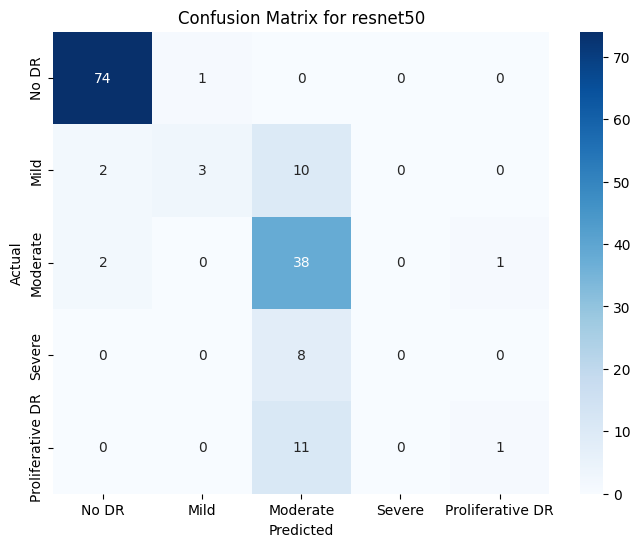

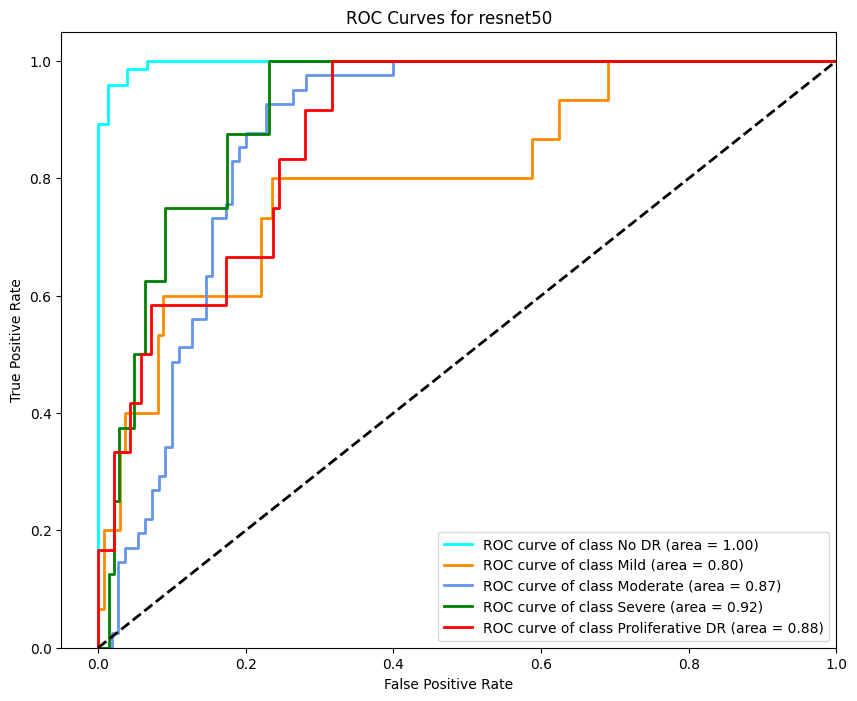


==================== Training resnet152 ====================



Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 85.6MB/s]


Epoch 1/5
----------
Train Loss: 0.9627 | Precision: 0.5234 | Recall: 0.6412 | F1 Score: 0.5725 | Specificity: 0.8870 | Sensitivity: 0.3255 | AUROC: 0.8408
Test Loss: 0.6968 | Precision: 0.5978 | Recall: 0.7417 | F1 Score: 0.6558 | Specificity: 0.9226 | Sensitivity: 0.3827 | AUROC: 0.9147
Validation metric improved (0.655814 --> 0.655814).  Saving model ...

Epoch 2/5
----------
Train Loss: 0.7133 | Precision: 0.6224 | Recall: 0.7329 | F1 Score: 0.6537 | Specificity: 0.9206 | Sensitivity: 0.3853 | AUROC: 0.9149
Test Loss: 0.6313 | Precision: 0.6275 | Recall: 0.7550 | F1 Score: 0.6738 | Specificity: 0.9306 | Sensitivity: 0.3947 | AUROC: 0.9451
Validation metric improved (0.673850 --> 0.673850).  Saving model ...

Epoch 3/5
----------
Train Loss: 0.6143 | Precision: 0.6782 | Recall: 0.7624 | F1 Score: 0.7115 | Specificity: 0.9343 | Sensitivity: 0.4545 | AUROC: 0.9406
Test Loss: 0.6983 | Precision: 0.6896 | Recall: 0.7682 | F1 Score: 0.7107 | Specificity: 0.9350 | Sensitivity: 0.4382 | AU

<ipython-input-7-76f88bbf2db7>:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Model saved to classifier_resnet152.pt
Test Metrics for resnet152:
  Precision: 0.7699
  Recall: 0.7748
  F1 Score: 0.7547
  Specificity: 0.9385
  Sensitivity: 0.5282
  AUROC: 0.9318


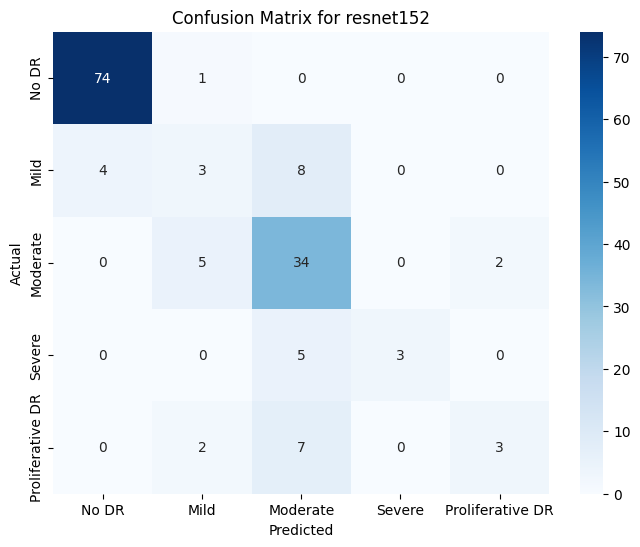

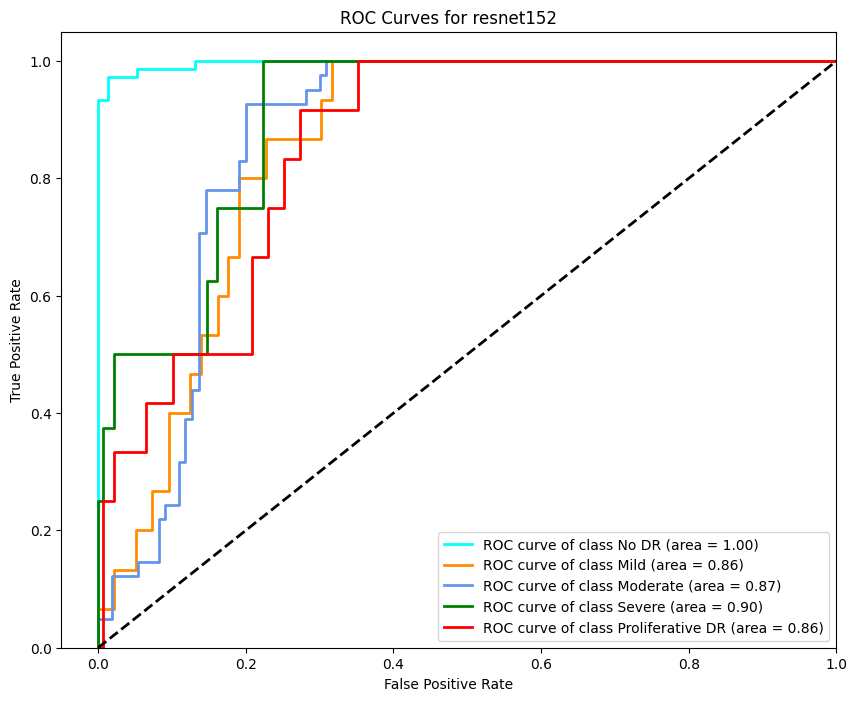


==================== Training densenet121 ====================



Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 69.1MB/s]


Epoch 1/5
----------
Train Loss: 1.0827 | Precision: 0.4595 | Recall: 0.5953 | F1 Score: 0.5174 | Specificity: 0.8644 | Sensitivity: 0.2870 | AUROC: 0.7900
Test Loss: 0.8247 | Precision: 0.6197 | Recall: 0.7417 | F1 Score: 0.6625 | Specificity: 0.9267 | Sensitivity: 0.3871 | AUROC: 0.9147
Validation metric improved (0.662478 --> 0.662478).  Saving model ...

Epoch 2/5
----------
Train Loss: 0.7562 | Precision: 0.5768 | Recall: 0.7212 | F1 Score: 0.6358 | Specificity: 0.9154 | Sensitivity: 0.3719 | AUROC: 0.9111
Test Loss: 0.6634 | Precision: 0.6197 | Recall: 0.7417 | F1 Score: 0.6625 | Specificity: 0.9267 | Sensitivity: 0.3871 | AUROC: 0.9325
Validation metric improved (0.662478 --> 0.662478).  Saving model ...

Epoch 3/5
----------
Train Loss: 0.7206 | Precision: 0.6224 | Recall: 0.7271 | F1 Score: 0.6592 | Specificity: 0.9203 | Sensitivity: 0.3899 | AUROC: 0.9145
Test Loss: 0.6236 | Precision: 0.6200 | Recall: 0.7550 | F1 Score: 0.6710 | Specificity: 0.9295 | Sensitivity: 0.3925 | AU

<ipython-input-7-76f88bbf2db7>:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Model saved to classifier_densenet121.pt
Test Metrics for densenet121:
  Precision: 0.7573
  Recall: 0.7682
  F1 Score: 0.7486
  Specificity: 0.9389
  Sensitivity: 0.5189
  AUROC: 0.9408


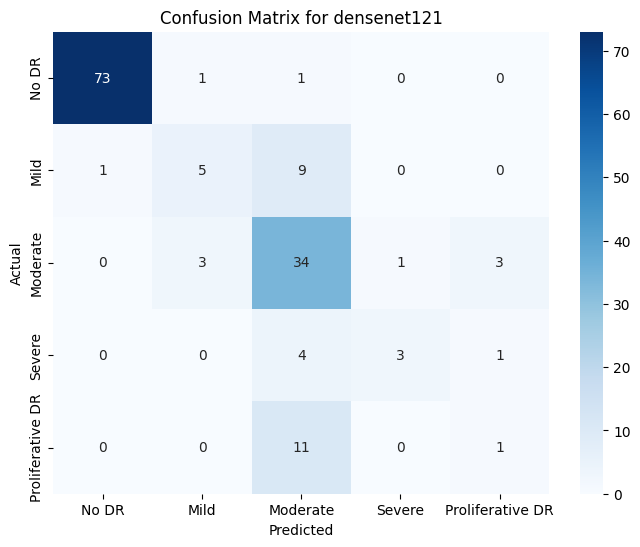

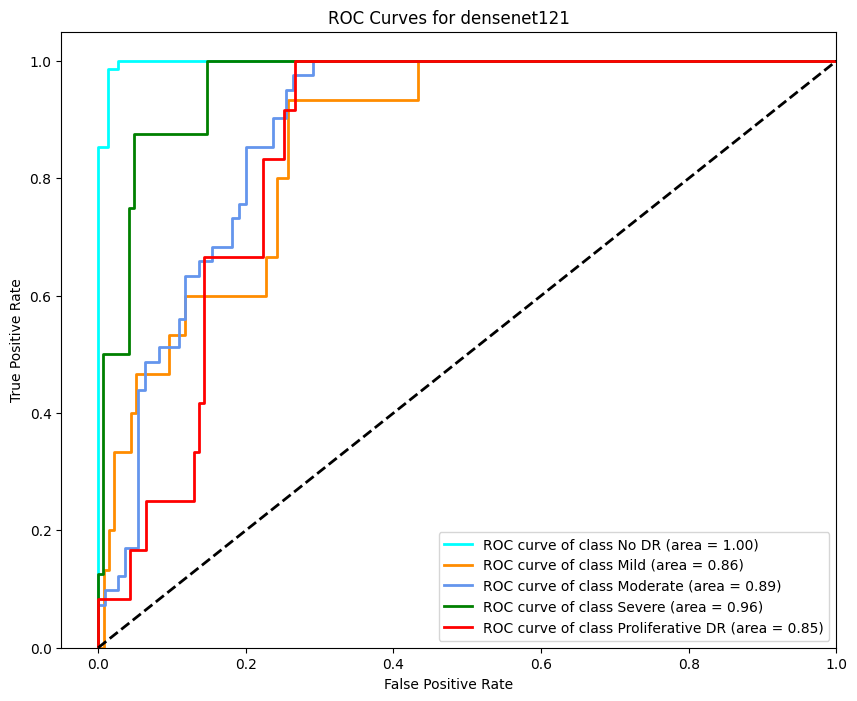


==================== Training efficientnetb0 ====================



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 87.0MB/s]


Epoch 1/5
----------
Train Loss: 1.3146 | Precision: 0.4459 | Recall: 0.4906 | F1 Score: 0.4428 | Specificity: 0.8344 | Sensitivity: 0.2513 | AUROC: 0.7105
Test Loss: 0.9438 | Precision: 0.3816 | Recall: 0.5497 | F1 Score: 0.4374 | Specificity: 0.8357 | Sensitivity: 0.2390 | AUROC: 0.8842
Validation metric improved (0.437358 --> 0.437358).  Saving model ...

Epoch 2/5
----------
Train Loss: 0.9017 | Precision: 0.5582 | Recall: 0.6894 | F1 Score: 0.6081 | Specificity: 0.8997 | Sensitivity: 0.3615 | AUROC: 0.8806
Test Loss: 0.7514 | Precision: 0.5794 | Recall: 0.7285 | F1 Score: 0.6421 | Specificity: 0.9165 | Sensitivity: 0.3707 | AUROC: 0.9198
Validation metric improved (0.642061 --> 0.642061).  Saving model ...

Epoch 3/5
----------
Train Loss: 0.7579 | Precision: 0.5856 | Recall: 0.7353 | F1 Score: 0.6472 | Specificity: 0.9197 | Sensitivity: 0.3796 | AUROC: 0.9124
Test Loss: 0.6586 | Precision: 0.6099 | Recall: 0.7417 | F1 Score: 0.6597 | Specificity: 0.9250 | Sensitivity: 0.3849 | AU

<ipython-input-7-76f88bbf2db7>:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Model saved to classifier_efficientnetb0.pt
Test Metrics for efficientnetb0:
  Precision: 0.7787
  Recall: 0.7748
  F1 Score: 0.7113
  Specificity: 0.9349
  Sensitivity: 0.4441
  AUROC: 0.9417


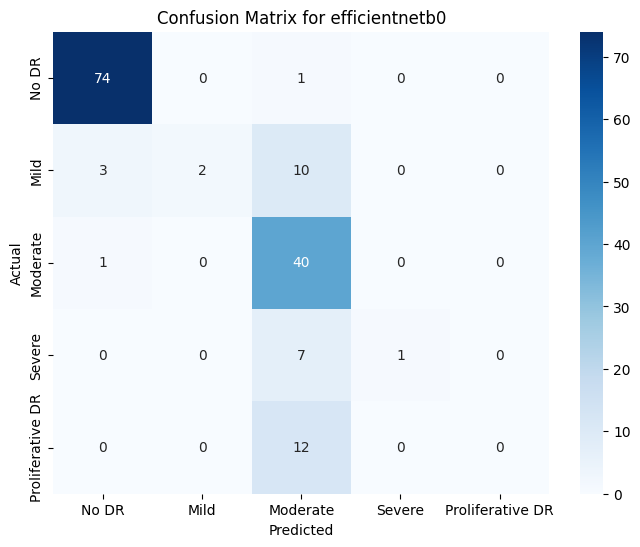

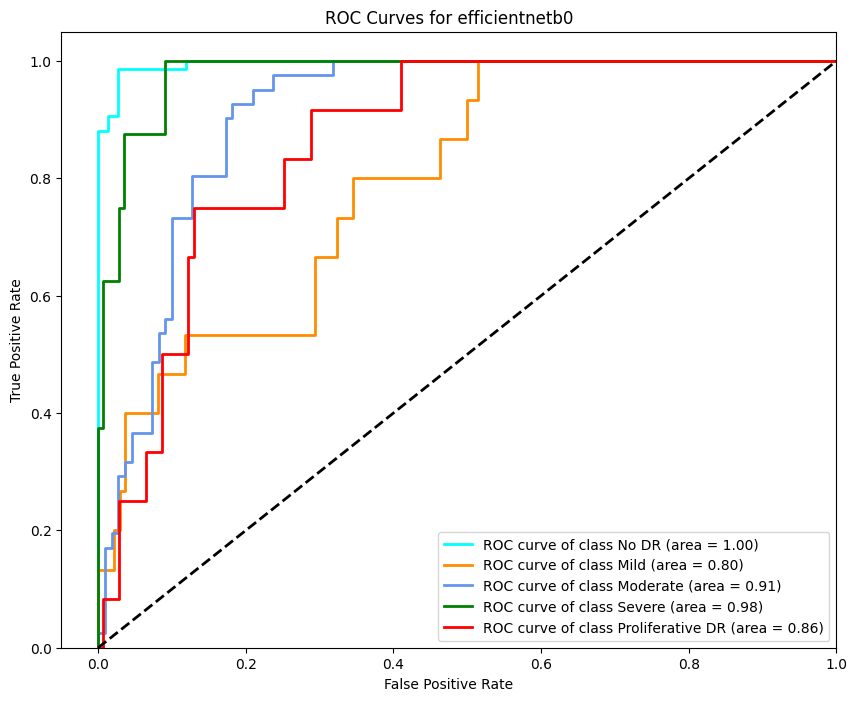


==================== Training inceptionv3 ====================



Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 31.5MB/s]


Epoch 1/5
----------
Train Loss: 1.5383 | Precision: 0.4558 | Recall: 0.5800 | F1 Score: 0.4901 | Specificity: 0.8483 | Sensitivity: 0.2737 | AUROC: 0.7779
Test Loss: 0.8019 | Precision: 0.5894 | Recall: 0.7351 | F1 Score: 0.6496 | Specificity: 0.9200 | Sensitivity: 0.3756 | AUROC: 0.9008
Validation metric improved (0.649590 --> 0.649590).  Saving model ...

Epoch 2/5
----------
Train Loss: 1.1033 | Precision: 0.5825 | Recall: 0.7282 | F1 Score: 0.6415 | Specificity: 0.9176 | Sensitivity: 0.3779 | AUROC: 0.9053
Test Loss: 0.7437 | Precision: 0.6140 | Recall: 0.7417 | F1 Score: 0.6612 | Specificity: 0.9258 | Sensitivity: 0.3849 | AUROC: 0.9049
Validation metric improved (0.661246 --> 0.661246).  Saving model ...

Epoch 3/5
----------
Train Loss: 1.0012 | Precision: 0.6696 | Recall: 0.7376 | F1 Score: 0.6612 | Specificity: 0.9236 | Sensitivity: 0.3902 | AUROC: 0.9125
Test Loss: 0.6372 | Precision: 0.6200 | Recall: 0.7550 | F1 Score: 0.6710 | Specificity: 0.9295 | Sensitivity: 0.3925 | AU

<ipython-input-7-76f88bbf2db7>:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Model saved to classifier_inceptionv3.pt
Test Metrics for inceptionv3:
  Precision: 0.6928
  Recall: 0.7682
  F1 Score: 0.7092
  Specificity: 0.9338
  Sensitivity: 0.4382
  AUROC: 0.9354


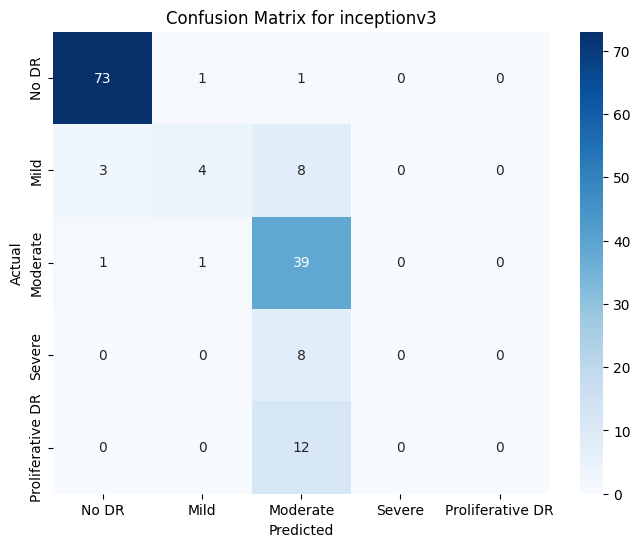

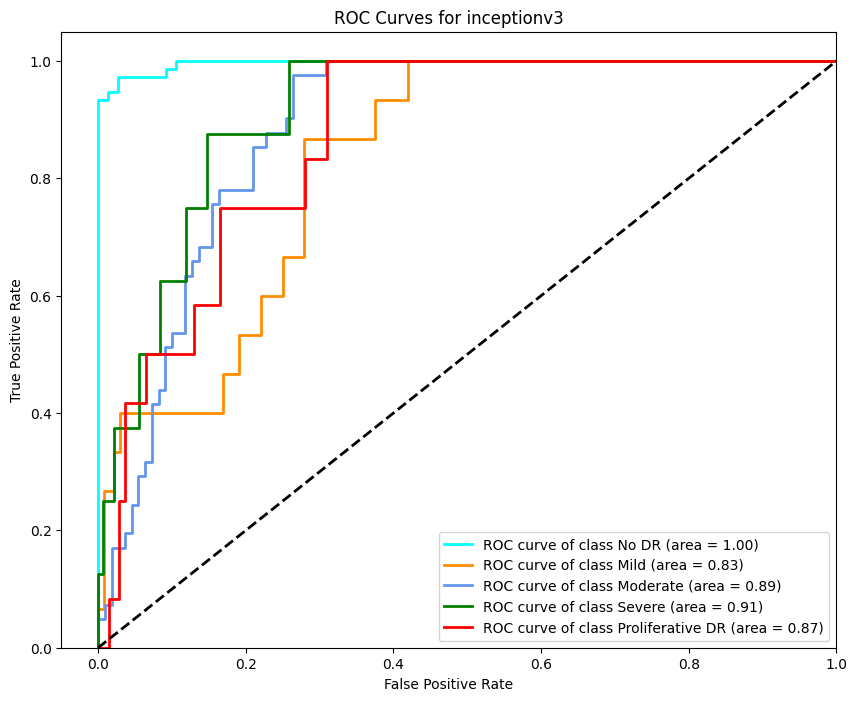


==================== Performing Max Voting Ensemble ====================

Voting Ensemble Predictions saved to submission_voting.csv

==================== Evaluation Metrics for Max Voting Ensemble ====================

Max Voting Ensemble Metrics:
  Precision: 0.7125
  Recall: 0.7748
  F1 Score: 0.7177
  Specificity: 0.9365
  Sensitivity: 0.4409
  AUROC: Not Available for Max Voting Ensemble


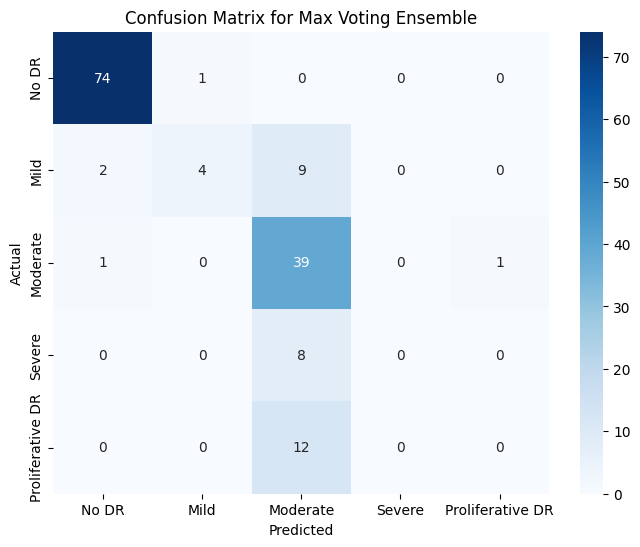

In [7]:
### Exploratory Data Analysis
# Split the data into training and test sets (85% train, 15% test)
train_data, test_data = train_test_split(sampled_train, test_size=0.15, random_state=42, stratify=sampled_train['diagnosis'])

# Save split data to CSVs (optional, for debugging or reuse)
train_csv = os.path.join(base_dir, 'train_split.csv')
test_csv_split = os.path.join(base_dir, 'test_split.csv')
train_data.to_csv(train_csv, index=False)
test_data.to_csv(test_csv_split, index=False)

images_folder = os.path.join(base_dir, 'train_images')
train_images_folder = os.path.join(base_dir, 'train_split_images')
test_images_folder = os.path.join(base_dir, 'test_split_images')

# Create subfolders if they don't exist
os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(test_images_folder, exist_ok=True)

# Load train and test splits
train_split = pd.read_csv(train_csv)
test_split = pd.read_csv(test_csv_split)

# Move images to respective folders
def copy_images(df, src_folder, dest_folder):
    for _, row in df.iterrows():
        image_name = f"{row['id_code']}.png"  # Replace with your image file extension if different
        src_path = os.path.join(src_folder, image_name)
        dest_path = os.path.join(dest_folder, image_name)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)

copy_images(train_split, images_folder, train_images_folder)
copy_images(test_split, images_folder, test_images_folder)

print(f"Images successfully split into subfolders:\n"
      f"Train images folder: {train_images_folder}\n"
      f"Test images folder: {test_images_folder}")

### Pre-define Class and Functions
class BlindnessDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            row = self.data.iloc[idx]
            img_path = os.path.join(self.root_dir, f"{row['id_code']}.png")
            label = row['diagnosis']
            image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            label = torch.tensor(label, dtype=torch.long)
            return image, label
        except Exception as e:
            print(f"Error loading image {idx}: {e}")
            # Return a dummy image and label in case of error
            return torch.zeros(3, 224, 224), torch.tensor(0, dtype=torch.long)

def enhance_image(image, use_clahe=True, clahe_clip_limit=2.0, clahe_tile_grid_size=(8, 8)):
    """
    Enhances the image using Histogram Equalization or CLAHE.

    Parameters:
        image (PIL.Image or np.ndarray): Input image.
        use_clahe (bool): Whether to apply CLAHE. If False, apply standard Histogram Equalization.
        clahe_clip_limit (float): Clip limit for CLAHE.
        clahe_tile_grid_size (tuple): Grid size for CLAHE.

    Returns:
        PIL.Image: Enhanced image as a Pillow image.
    """
    # Convert PIL image to numpy array if needed
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    # Convert to grayscale if the image is not already
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    if use_clahe:
        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=clahe_tile_grid_size)
        enhanced = clahe.apply(gray)
    else:
        # Apply Histogram Equalization
        enhanced = cv2.equalizeHist(gray)

    # Convert back to 3-channel RGB for consistency
    enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)

    # Convert back to PIL Image for PyTorch compatibility
    return Image.fromarray(enhanced_rgb)

# Custom transform to include image enhancement
class ImageEnhancementTransform:
    def __init__(self, use_clahe=True, clahe_clip_limit=2.0, clahe_tile_grid_size=(8, 8)):
        self.use_clahe = use_clahe
        self.clahe_clip_limit = clahe_clip_limit
        self.clahe_tile_grid_size = clahe_tile_grid_size

    def __call__(self, image):
        return enhance_image(image, self.use_clahe, self.clahe_clip_limit, self.clahe_tile_grid_size)

### Transforms
from torchvision.models import Inception_V3_Weights, ResNet50_Weights, ResNet152_Weights, DenseNet121_Weights, EfficientNet_B0_Weights

def get_transforms(model_name):
    if model_name in ["resnet50", "resnet152", "densenet121", "efficientnetb0"]:
        train_transforms = transforms.Compose([
            ImageEnhancementTransform(use_clahe=True),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),  # Augmentation
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225))
        ])
        test_transforms = transforms.Compose([
            ImageEnhancementTransform(use_clahe=True),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225))
        ])
    elif model_name == "inceptionv3":
        train_transforms = transforms.Compose([
            ImageEnhancementTransform(use_clahe=True),
            transforms.RandomResizedCrop(299),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225))
        ])
        test_transforms = transforms.Compose([
            ImageEnhancementTransform(use_clahe=True),
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225))
        ])
    else:
        raise ValueError(f"Transforms for {model_name} are not defined.")

    return train_transforms, test_transforms

### Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0.0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation metric improved.
            verbose (bool): If True, prints a message for each validation metric improvement.
            delta (float): Minimum change in the monitored metric to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path
        self.best_metric = None

    def __call__(self, metric, model):
        score = metric

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(metric, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(metric, model)
            self.counter = 0

    def save_checkpoint(self, metric, model):
        if self.verbose:
            print(f'Validation metric improved ({self.best_score:.6f} --> {metric:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.best_metric = metric

### Evaluation Metrics Function
def evaluate_metrics(y_true, y_pred, num_classes, y_pred_probs=None):
    """
    Computes Precision, Recall, F1 Score, Specificity, Sensitivity, and AUROC.

    Args:
        y_true (list or array): True class labels.
        y_pred (list or array): Predicted class labels.
        num_classes (int): Number of classes.
        y_pred_probs (list or array, optional): Predicted probabilities for each class.

    Returns:
        dict: Dictionary containing the computed metrics.
    """
    metrics = {}
    metrics['precision'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['recall'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Compute confusion matrix for specificity and sensitivity
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    tn = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)  # In multi-class, tp for each class is the diagonal

    specificity = tn / (tn + fp + 1e-8)  # Added epsilon to prevent division by zero
    sensitivity = tp / (tp + fn + 1e-8)

    metrics['specificity'] = np.mean(specificity)
    metrics['sensitivity'] = np.mean(sensitivity)

    if y_pred_probs is not None and num_classes > 1:
        try:
            y_true_one_hot = label_binarize(y_true, classes=range(num_classes))
            y_pred_probs = np.array(y_pred_probs)
            metrics['auroc'] = roc_auc_score(
                y_true_one_hot, y_pred_probs, average='weighted', multi_class='ovr'
            )
        except Exception as e:
            metrics['auroc'] = None
            print(f"AUROC computation failed: {e}")
    else:
        metrics['auroc'] = None

    return metrics

### Plotting Functions
def plot_confusion_matrix_custom(y_true, y_pred, classes, model_name):
    """
    Plots the confusion matrix using seaborn heatmap.

    Args:
        y_true (list or array): True class labels.
        y_pred (list or array): Predicted class labels.
        classes (list): List of class names.
        model_name (str): Name of the model for the title.
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

def plot_roc_curve_custom(y_true, y_pred_probs, classes, model_name):
    """
    Plots the ROC curves for each class.

    Args:
        y_true (list or array): True class labels.
        y_pred_probs (list or array): Predicted probabilities for each class.
        classes (list): List of class names.
        model_name (str): Name of the model for the title.
    """
    y_true_binary = label_binarize(y_true, classes=range(len(classes)))
    y_true_binary = np.array(y_true_binary)  # Ensure it's a NumPy array
    y_pred_probs = np.array(y_pred_probs)    # Ensure it's a NumPy array
    n_classes = y_true_binary.shape[1]

    # Check if y_pred_probs has the correct shape
    if y_pred_probs.shape[1] != n_classes:
        print(f"Error: Number of classes in y_pred_probs ({y_pred_probs.shape[1]}) does not match y_true_binary ({n_classes}).")
        return

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_probs[:, i])
        roc_auc[i] = roc_auc_score(y_true_binary[:, i], y_pred_probs[:, i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = roc_auc_score(y_true_binary, y_pred_probs, average="micro")

    # Plot ROC curves
    plt.figure(figsize=(10,8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

### Model Creation Function
def create_model(model_name="resnet50", num_classes=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model_name == "resnet50":
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
    elif model_name == "resnet152":
        model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
    elif model_name == "inceptionv3":
        model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
        num_ftrs = model.fc.in_features
        # Replace the main classifier
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
        # Replace the auxiliary classifier
        if model.aux_logits:
            num_ftrs_aux = model.AuxLogits.fc.in_features
            model.AuxLogits.fc = nn.Sequential(
                nn.Linear(num_ftrs_aux, 512),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(512, num_classes),
                nn.LogSoftmax(dim=1)
            )
    elif model_name == "efficientnetb0":
        model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
    elif model_name == "densenet121":
        model = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
    else:
        raise ValueError(f"Model {model_name} is not supported.")

    model = model.to(device)
    return model

### Training Function with Early Stopping
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, model_name, num_epochs=5, patience=3):
    history = {
        'train_loss': [], 'test_loss': [],
        'precision': [], 'recall': [], 'f1_score': [],
        'specificity': [], 'sensitivity': [], 'auroc': []
    }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    early_stopping = EarlyStopping(patience=patience, verbose=True, delta=0.0, path='best_model.pt')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            all_preds = []
            all_labels = []
            all_probs = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if model_name == "inceptionv3" and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    probs = torch.exp(outputs)  # Since using LogSoftmax

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.detach().cpu().numpy())  # Detach here

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            metrics = evaluate_metrics(all_labels, all_preds, num_classes=dataset_sizes['num_classes'], y_pred_probs=all_probs)
            epoch_precision = metrics['precision']
            epoch_recall = metrics['recall']
            epoch_f1 = metrics['f1_score']
            epoch_specificity = metrics['specificity']
            epoch_sensitivity = metrics['sensitivity']
            epoch_auroc = metrics['auroc']

            history[f'{phase}_loss'].append(epoch_loss)
            history['precision'].append(epoch_precision)
            history['recall'].append(epoch_recall)
            history['f1_score'].append(epoch_f1)
            history['specificity'].append(epoch_specificity)
            history['sensitivity'].append(epoch_sensitivity)
            history['auroc'].append(epoch_auroc)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} | Precision: {epoch_precision:.4f} | '
                  f'Recall: {epoch_recall:.4f} | F1 Score: {epoch_f1:.4f} | '
                  f'Specificity: {epoch_specificity:.4f} | Sensitivity: {epoch_sensitivity:.4f} | '
                  f'AUROC: {epoch_auroc:.4f}')

            if phase == 'test':
                early_stopping(epoch_f1, model)
                if early_stopping.early_stop:
                    print("Early stopping triggered.")
                    model.load_state_dict(torch.load('best_model.pt'))
                    return model, history

        print()

    model.load_state_dict(torch.load('best_model.pt'))
    return model, history

### Main Training and Evaluation Loop with Ensemble
def main():
    # List of models to train
    model_names = ["resnet50", "resnet152", "densenet121", "efficientnetb0", "inceptionv3"]

    # Initialize dictionaries to store models and their test predictions
    trained_models = {}
    test_predictions = {}
    test_labels = None

    # Initialize a dictionary to store individual model predictions on test set for CSV
    test_preds_individual = {model_name: [] for model_name in model_names}  # ### Added

    # Load Test Data
    test_csv = os.path.join(base_dir, 'test_split.csv')  # Assuming test_split.csv exists
    test_images_folder = os.path.join(base_dir, 'test_split_images')  # Assuming test_split_images are placed here

    # Load True Labels for Test Set
    test_data_full = pd.read_csv(test_csv)
    test_ids = test_data_full['id_code']
    test_true = test_data_full['diagnosis'].values

    for model_name in model_names:
        print(f"\n{'='*20} Training {model_name} {'='*20}\n")

        # Define transforms
        train_transforms, test_transforms = get_transforms(model_name)

        # Create the training and test datasets
        train_dataset = BlindnessDataset(train_csv, train_images_folder, transform=train_transforms)
        test_dataset_model = BlindnessDataset(test_csv_split, test_images_folder, transform=test_transforms)

        # Create DataLoaders with num_workers=0 to prevent worker crashes
        dataloaders = {
            'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0),
            'test': DataLoader(test_dataset_model, batch_size=32, shuffle=False, num_workers=0)
        }

        dataset_sizes = {
            'train': len(train_dataset),
            'test': len(test_dataset_model),
            'num_classes': len(train_dataset.data['diagnosis'].unique())
        }

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Set hyperparameters directly
        best_lr = 1e-4
        best_optimizer = 'Adam'
        best_weight_decay = 1e-5

        # Train final model with set hyperparameters
        model = create_model(model_name, num_classes=dataset_sizes['num_classes'])

        if best_optimizer == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
        else:
            optimizer = optim.SGD(model.parameters(), lr=best_lr, weight_decay=best_weight_decay, momentum=0.9)

        scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        criterion = nn.NLLLoss()

        model, history = train_model(
            model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device,
            model_name=model_name,
            num_epochs=5, patience=3  # Adjust as needed
        )

        # Save the trained model
        save_path = f'classifier_{model_name}.pt'
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'class_to_idx': {'No DR': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Proliferative DR': 4}
        }, save_path)
        shutil.copy(save_path, output_dir + save_path)

        print(f"Model saved to {save_path}")

        ### Evaluation on Test Set
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for inputs, labels in dataloaders['test']:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)

                if model_name == "inceptionv3":
                    # During evaluation, InceptionV3 returns only the main output
                    main_output = outputs
                    probs = torch.exp(main_output)
                    _, preds = torch.max(main_output, 1)
                else:
                    probs = torch.exp(outputs)
                    _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.detach().cpu().numpy())  # Detach here

        test_metrics = evaluate_metrics(all_labels, all_preds, num_classes=dataset_sizes['num_classes'], y_pred_probs=all_probs)
        print(f"Test Metrics for {model_name}:")
        print(f"  Precision: {test_metrics['precision']:.4f}")
        print(f"  Recall: {test_metrics['recall']:.4f}")
        print(f"  F1 Score: {test_metrics['f1_score']:.4f}")
        print(f"  Specificity: {test_metrics['specificity']:.4f}")
        print(f"  Sensitivity: {test_metrics['sensitivity']:.4f}")
        print(f"  AUROC: {test_metrics['auroc']:.4f}")

        # Plot Confusion Matrix and ROC Curve for the individual model
        class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
        plot_confusion_matrix_custom(all_labels, all_preds, classes=class_names, model_name=model_name)
        plot_roc_curve_custom(all_labels, all_probs, classes=class_names, model_name=model_name)  # ### Added

        # Store the trained model and its test predictions
        trained_models[model_name] = model
        test_predictions[model_name] = all_probs
        if test_labels is None:
            test_labels = all_labels

        ### Make Predictions on Test Set
        model.eval()

        # Store predictions
        test_preds_individual[model_name] = all_preds

    ### Max Voting Ensemble
    print(f"\n{'='*20} Performing Max Voting Ensemble {'='*20}\n")

    # Convert dictionary values to a list and then to a NumPy array with dtype=int
    voting_preds = np.array(list(test_preds_individual.values()), dtype=int)  # Shape: (num_models, num_samples)

    # Check if voting_preds has any data
    if voting_preds.size == 0:
        print("Error: No predictions found in test_preds_individual. Ensure that predictions are being made correctly.")
        return

    # Perform majority voting along the first axis (models)
    final_votes = mode(voting_preds, axis=0, keepdims=False).mode

    # Ensure final_votes is 1D
    if final_votes.ndim > 1:
        final_votes = final_votes.squeeze()

    # Verify the length of final_votes matches test_ids
    if len(final_votes) != len(test_ids):
        print(f"Error: Length of final_votes ({len(final_votes)}) does not match length of test_ids ({len(test_ids)}).")
        return

    # Save Voting Ensemble Predictions to CSV with individual model predictions
    voting_submission = pd.DataFrame({
        'id_code': test_ids,
        'diagnosis': final_votes
    })

    # ### Added: Adding individual model predictions to the CSV
    for model_name in model_names:
        voting_submission[f'pred_{model_name}'] = test_preds_individual[model_name]

    voting_submission.to_csv('submission_voting.csv', index=False)
    shutil.copy('submission_voting.csv', output_dir + 'submission_voting.csv')
    print("Voting Ensemble Predictions saved to submission_voting.csv")

    ### Print Evaluation Metrics for Max Voting Ensemble
    print(f"\n{'='*20} Evaluation Metrics for Max Voting Ensemble {'='*20}\n")
    # Since max voting provides only class predictions, we cannot compute AUROC without probabilities
    voting_metrics = evaluate_metrics(test_true, final_votes, num_classes=dataset_sizes['num_classes'], y_pred_probs=None)
    print("Max Voting Ensemble Metrics:")
    print(f"  Precision: {voting_metrics['precision']:.4f}")
    print(f"  Recall: {voting_metrics['recall']:.4f}")
    print(f"  F1 Score: {voting_metrics['f1_score']:.4f}")
    print(f"  Specificity: {voting_metrics['specificity']:.4f}")
    print(f"  Sensitivity: {voting_metrics['sensitivity']:.4f}")
    print(f"  AUROC: Not Available for Max Voting Ensemble")

    ### Add Confusion Matrix for Max Voting Ensemble
    plot_confusion_matrix_custom(test_true, final_votes, classes=class_names, model_name='Max Voting Ensemble')

if __name__ == "__main__":
    main()